In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/cnn_2_1

/content/drive/MyDrive/cnn_2_1


In [ ]:
# 필요한 라이브러리 추가
import os
import warnings
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage, RandomApply, transforms,RandomRotation,RandomVerticalFlip,RandomResizedCrop,RandomHorizontalFlip
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn import model_selection

import math
import time
import datetime

In [ ]:
# 데이터셋 읽어서 df 변수에 넣기
df = pd.read_pickle("./LSWMD.pkl")

In [ ]:
print(df.info()) # 데이터 정보 출력
display(df.head(4)) # 데이터 위에서 4개 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB
None


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]


In [ ]:
# trianTestLabel,failureType 가 배열로 들어있어서 스트링으로 변경해서 넣고 데이터 확인

f_squeeze = lambda x: str(np.squeeze(x))
df["failureType"] = df["failureType"].map(f_squeeze)
df["trianTestLabel"] = df["trianTestLabel"].map(f_squeeze)
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none


In [ ]:
# 라벨이 없는 데이터 제거 후 라벨 데이터 확인  * none 라벨 포함
eliminate_list = [ '[]']
df_with_label = df.query(f"failureType not in {eliminate_list}")
print(f"{len(df_with_label)}")
print("Label list: ", df_with_label["failureType"].unique())
df_with_label.head(3)

172950
Label list:  ['none' 'Loc' 'Edge-Loc' 'Center' 'Edge-Ring' 'Scratch' 'Random'
 'Near-full' 'Donut']


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none


In [ ]:
# 각 라벨 숫자와 맵핑 후 라벨 있는 데이터 파일로 저장
class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3,
    'Scratch': 4,
    'Random': 5,
    'Near-full': 6,
    'Donut': 7,
    'none' : 8
}
idx2class = {v: k for k, v in class2idx.items()}

# class2idx_json_path = "./config_class2idx.json"
# with open(class2idx_json_path, "w") as f:
#     json.dump(class2idx, f)

# df_with_label["encoded_labels"] = df_with_label["failureType"].replace(class2idx)

# print(df_with_label["encoded_labels"].value_counts()) # 라벨별 데이터 갯수 확인
# df_with_label.reset_index(inplace=True, drop=True)
# df_with_label.to_pickle("./LSWMD_is_label.pkl")
# df_with_label.head(3)

In [ ]:
# 라벨이 존재하는 데이터셋 isLabelData 변수에 넣고 각 라벨별 데이터셋 저장 라벨별 갯수 출력

isLabelData = pd.read_pickle("./LSWMD_is_label.pkl")

data0 = isLabelData[isLabelData['encoded_labels'].isin([0])]
data0 = data0.reset_index(drop=True)
print('data0 size : ', len(data0))
data0.to_pickle("data0.pickle")

data1 = isLabelData[isLabelData['encoded_labels'].isin([1])]
data1 = data1.reset_index( drop=True)
print('data1 size : ', len(data1))
data1.to_pickle("data1.pickle")

data2 = isLabelData[isLabelData['encoded_labels'].isin([2])]
data2 = data2.reset_index(drop=True)
print('data2 size : ', len(data2))
data2.to_pickle("data2.pickle")

data3 = isLabelData[isLabelData['encoded_labels'].isin([3])]
data3 = data3.reset_index(drop=True)
print('data3 size : ', len(data3))
data3.to_pickle("data3.pickle")

data4 = isLabelData[isLabelData['encoded_labels'].isin([4])]
data4 = data4.reset_index(drop=True)
print('data4 size : ', len(data4))
data4.to_pickle("data4.pickle")

data5 = isLabelData[isLabelData['encoded_labels'].isin([5])]
data5 = data5.reset_index(drop=True)
print('data5 size : ', len(data5))
data5.to_pickle("data5.pickle")

data6 = isLabelData[isLabelData['encoded_labels'].isin([6])]
data6 = data6.reset_index(drop=True)
print('data6 size : ', len(data6))
data6.to_pickle("data6.pickle")

data7 = isLabelData[isLabelData['encoded_labels'].isin([7])]
data7 = data7.reset_index(drop=True)
print('data7 size : ', len(data7))
data7.to_pickle("data7.pickle")

data8 = isLabelData[isLabelData['encoded_labels'].isin([8])]
data8 = data8.reset_index(drop=True)
print('data8 size : ', len(data8))
data8.to_pickle("data8.pickle")

data0 size :  3593
data1 size :  5189
data2 size :  4294
data3 size :  9680
data4 size :  1193
data5 size :  866
data6 size :  149
data7 size :  555
data8 size :  147431


In [ ]:
# 데이터를 10000개로 하려고 했으나 데이터 사이즈가 커서 램 부족으로 1000개로 테스트함. ㅠ

# 라벨별 데이터 10000개로 만들기 위한 transform.Compose 함수 정의

sampleTransform = Compose([
    # RandomRotation(45),  # 랜덤 각도조절
    # RandomVerticalFlip(),  # 랜덤으로 상하 반전
    # RandomHorizontalFlip(),  # 랜덤으로 좌우 반전
    # #RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.8, 1.25)), # 랜덤 변형
    Resize((224,224)),
    RandomRotation(45),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    #RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.8, 1.25)),
])

# 데이터 10000개로 증량 및 감축

def sampling(ds):
  limit = 300
  # 10000개 이하면 10000개가 될때 까지 데이터 증량

  num_add = limit
  idx = 0

  df = pd.DataFrame()
  while len(df) < limit :
    for i, t in ds.iterrows():
      idx = idx + 1
      img = Image.fromarray(t.waferMap.astype('uint8'))
      img = sampleTransform(img)
      n_img = np.array(img)
      print(n_img.shape)
      df = df.append({
          'waferMap': n_img,
          'encoded_labels': t.encoded_labels,
          'failureType': t.failureType
      }, ignore_index=True)
      if idx == num_add:
        break

  return df



In [ ]:
# 각 라벨 데이터셋 데이터 증량 및 감축 함수 호출
data0 = sampling(data0)
data1 = sampling(data1)
data2 = sampling(data2)
data3 = sampling(data3)
data4 = sampling(data4)
data5 = sampling(data5)
data6 = sampling(data6)
data7 = sampling(data7)
data8 = sampling(data8)

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-5-6f9338ed16fa>:34: FutureWarning: The frame.appen

In [ ]:
# 데이터 증량 및 감축 확인을 위해 사이즈 출력 후 pickle 파일 저장
print('data0 size : ', len(data0))
data0 = data0.reset_index(drop=True)
data0.to_pickle("data0_s.pickle")

print('data1 size : ', len(data1))
data1 = data1.reset_index(drop=True)
data1.to_pickle("data1_s.pickle")

print('data2 size : ', len(data2))
data2 = data2.reset_index(drop=True)
data2.to_pickle("data2_s.pickle")

print('data3 size : ', len(data3))
data3 = data3.reset_index(drop=True)
data3.to_pickle("data3_s.pickle")

print('data4 size : ', len(data4))
data4 = data4.reset_index(drop=True)
data4.to_pickle("data4_s.pickle")

print('data5 size : ', len(data5))
data5 = data5.reset_index(drop=True)
data5.to_pickle("data5_s.pickle")

print('data6 size : ', len(data6))
data6 = data6.reset_index(drop=True)
data6.to_pickle("data6_s.pickle")

print('data7 size : ', len(data7))
data7 = data7.reset_index(drop=True)
data7.to_pickle("data7_s.pickle")

print('data8 size : ', len(data8))
data8 = data8.reset_index(drop=True)
data8.to_pickle("data8_s.pickle")

data0 size :  300
data1 size :  300
data2 size :  300
data3 size :  300
data4 size :  300
data5 size :  300
data6 size :  300
data7 size :  300
data8 size :  300


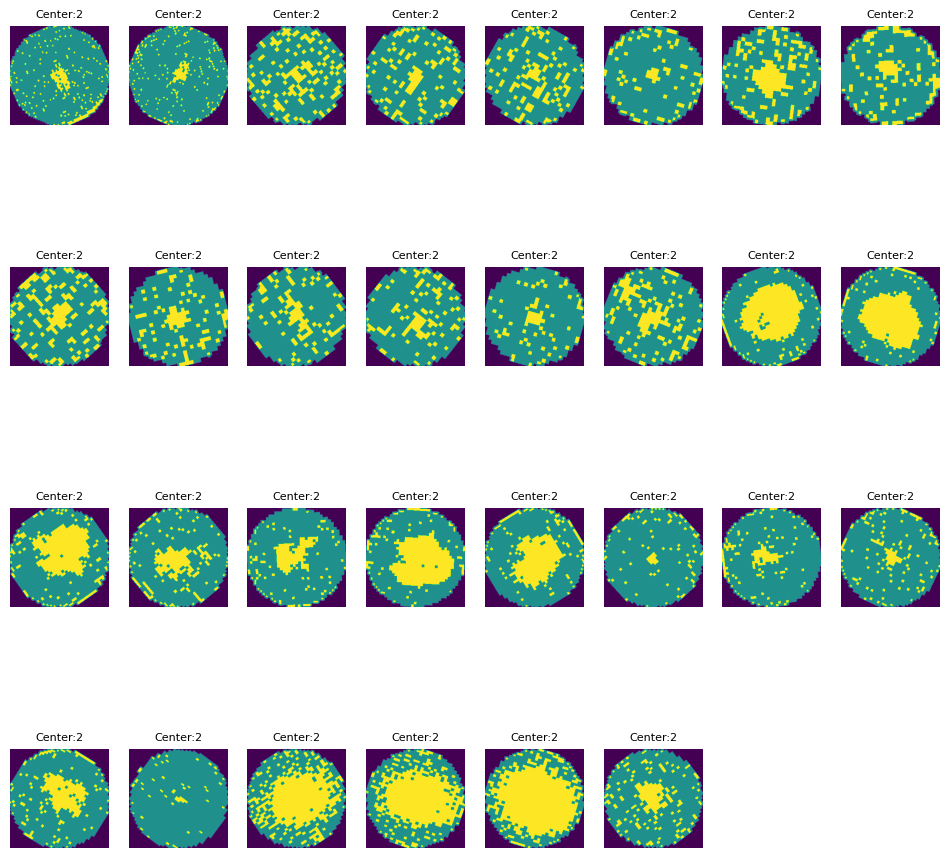

In [ ]:
# 증량된 이미지 확인
idx2class = {v: k for k, v in class2idx.items()}
batch_size = 30
basic = 0
plt.figure(figsize=(12, 12))
for i in range(basic, basic+batch_size):
    ax = plt.subplot(4, 8,i-(basic-1))
    ax.axis("off")
    ax.imshow(data2["waferMap"][i])
    ax.set_title(
        f'{idx2class[data2["encoded_labels"][i]]}:{str(data2["encoded_labels"][i])}', fontsize=8)


In [ ]:
# 다음 작업 시작시에 빠른 시작을 위해 위 과정 생략 증량된 데이터셋 불러오기

data0_s = pd.read_pickle("./data0_s.pickle")
data1_s = pd.read_pickle("./data1_s.pickle")
data2_s = pd.read_pickle("./data2_s.pickle")
data3_s = pd.read_pickle("./data3_s.pickle")
data4_s = pd.read_pickle("./data4_s.pickle")
data5_s = pd.read_pickle("./data5_s.pickle")
data6_s = pd.read_pickle("./data6_s.pickle")
data7_s = pd.read_pickle("./data7_s.pickle")
data8_s = pd.read_pickle("./data8_s.pickle")

In [ ]:
# 2차원 -> 3차원 변환
def tran3d(ds, limit):
  count = 0
  for idx, t in ds.iterrows():
    if count == limit: break
    count = count+1
    img = Image.fromarray(t.waferMap.astype('uint8'))
    # resized_img = img.resize((224, 224))
    arr_resized = np.asarray(img)

    image_shape = np.shape(arr_resized)
    arr_3d = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.float32)

    for i in range(image_shape[0]):
        for j in range(image_shape[1]):
            if arr_resized[i][j] == 0:
                arr_3d[i][j] = [0, 0, 0]  # 검정
            elif arr_resized[i][j] == 1:
                arr_3d[i][j] = [0, 200, 255]  # 청록
            elif arr_resized[i][j] == 2:
                arr_3d[i][j] = [200, 50, 0]  # 노랑

    img = torch.tensor(arr_3d, dtype = torch.float32)
    img = img.permute(2,0,1)
    ds.at[idx, 'waferMap'] = img

  return ds[:limit]

In [ ]:
# 3차원 변환 데이터셋 pickle 파일 저장
limit = 20

data0_color = tran3d(data0_s,limit)
data0_color.to_pickle("data0_color_"+str(limit)+".pickle")

data1_color = tran3d(data1_s,limit)
data1_color.to_pickle("data1_color_"+str(limit)+".pickle")

data2_color = tran3d(data2_s,limit)
data2_color.to_pickle("data2_color_"+str(limit)+".pickle")

data3_color = tran3d(data3_s,limit)
data3_color.to_pickle("data3_color_"+str(limit)+".pickle")

data4_color = tran3d(data4_s,limit)
data4_color.to_pickle("data4_color_"+str(limit)+".pickle")

data5_color = tran3d(data5_s,limit)
data5_color.to_pickle("data5_color_"+str(limit)+".pickle")

data6_color = tran3d(data6_s,limit)
data6_color.to_pickle("data6_color_"+str(limit)+".pickle")

data7_color = tran3d(data7_s,limit)
data7_color.to_pickle("data7_color_"+str(limit)+".pickle")

data8_color = tran3d(data8_s,limit)
data8_color.to_pickle("data8_color_"+str(limit)+".pickle")

In [ ]:
# 다음 작업 시작시에 빠른 시작을 위해 위 과정 생략 3차원 변환 데이터셋 불러오기
limit = 3000

data0_color = pd.read_pickle("./data0_color_"+str(limit)+".pickle")
data1_color = pd.read_pickle("./data1_color_"+str(limit)+".pickle")
data2_color = pd.read_pickle("./data2_color_"+str(limit)+".pickle")
data3_color = pd.read_pickle("./data3_color_"+str(limit)+".pickle")
data4_color = pd.read_pickle("./data4_color_"+str(limit)+".pickle")
data5_color = pd.read_pickle("./data5_color_"+str(limit)+".pickle")
data6_color = pd.read_pickle("./data6_color_"+str(limit)+".pickle")
data7_color = pd.read_pickle("./data7_color_"+str(limit)+".pickle")
data8_color = pd.read_pickle("./data8_color_"+str(limit)+".pickle")

class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3,
    'Scratch': 4,
    'Random': 5,
    'Near-full': 6,
    'Donut': 7,
    'none' : 8
}
idx2class = {v: k for k, v in class2idx.items()}


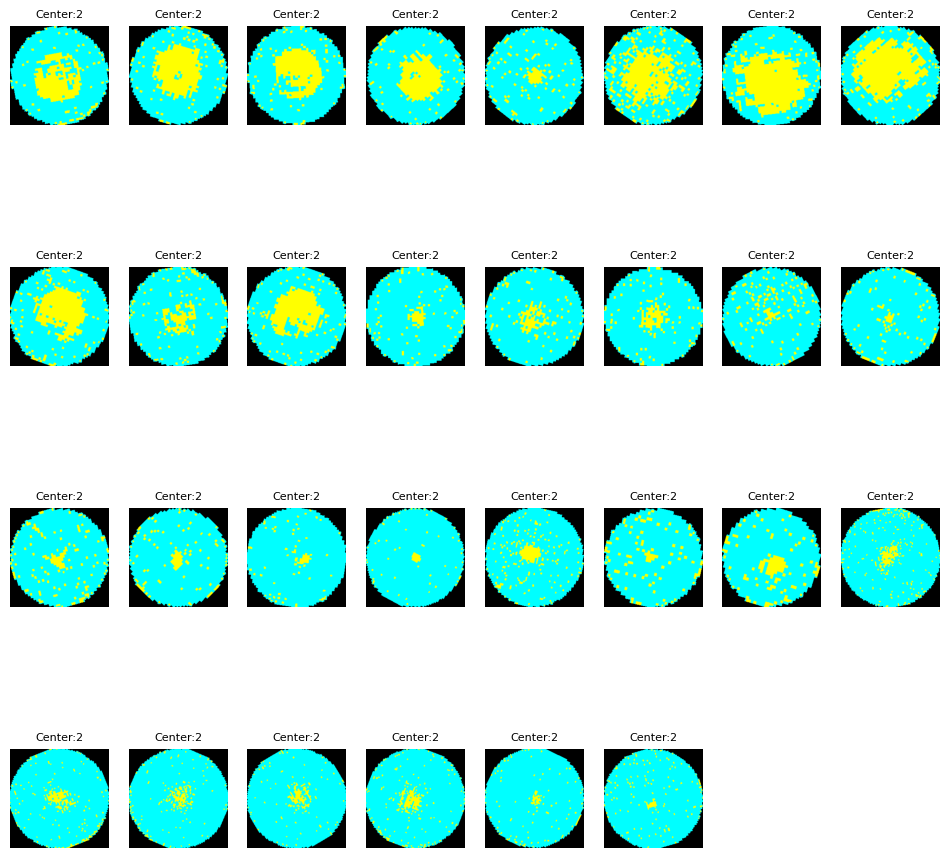

In [ ]:
# 3차원 이미지 확인
select_ds = data2_color
idx2class = {v: k for k, v in class2idx.items()}
batch_size = 30
start_length = 800
plt.figure(figsize=(12, 12))
for i in range(start_length, start_length+batch_size):
    ax = plt.subplot(4, 8, i-(start_length-1))
    ax.axis("off")
    ax.imshow(select_ds["waferMap"][i].permute(1,2,0))
    ax.set_title(
        f'{idx2class[select_ds["encoded_labels"][i]]}:{str(select_ds["encoded_labels"][i])}', fontsize=8)

In [ ]:
# 라벨 별 데이터셋 병합

merge_df = pd.concat([data0_color,data1_color, data2_color,data3_color,data4_color,data5_color,data6_color,data7_color,data8_color])
print(f"merge_df: {len(merge_df)}")

merge_df: 27000


In [ ]:
 # train data 65% val data 20% test data 15%로 나누기 각 데이터셋 저장
merge_df = merge_df.sample(frac=1, random_state=1)

train_data_length = int(0.85*len(merge_df))

df_train, df_test = merge_df[:train_data_length], merge_df[train_data_length:]
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

train_data_length = int(0.765*len(df_train))

df_train, df_val = df_train[:train_data_length], df_train[train_data_length:]
print(f"training: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}, (all: {len(merge_df)})")

df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

df_train.to_pickle("dataset_train.pickle")
df_val.to_pickle("dataset_val.pickle")
df_test.to_pickle("dataset_test.pickle")

training: 17556, val: 5394, test: 4050, (all: 27000)


In [ ]:
# custom dataset class 정의
class BasicDataset(data.Dataset):
    def __init__(self, x_tensor):
        self.x = x_tensor

    def __getitem__(self, index):
        # print(type(self.x.waferMap[index]))
        # print(self.x.encoded_labels[index])
        return (self.x.waferMap[index],int(self.x.encoded_labels[index]))

    def __len__(self):
        return len(self.x)

AttributeError: ignored

In [ ]:
# CNN 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        #공통
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

        #conv-poo1-conv 그룹1
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)

        #conv-poo1-conv 그룹2
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,padding=1)

        #conv-poo1-conv 그룹3
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        #conv-poo1-conv 그룹4
        self.conv4_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv4_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,padding=1)

        #conv-poo1-conv 그룹5
        self.conv5_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv5_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,padding=1)


        #flatten
        self.fc0 = nn.Linear(2304, 4608);

        #flatten
        self.fc1 = nn.Linear(4608, 512);

        #dense
        self.fc2 = nn.Linear(512, 9);

    def forward(self, x):
        #conv-poo1-conv 그룹1
        x = self.conv1_1(x)
        x = self.relu(x)
        #x = self.bn1(x)
        x = self.pool(x)
        x = self.conv1_2(x)
        x = self.relu(x)
        #x = self.bn1(x)

        #conv-poo1-conv 그룹2
        x = self.conv2_1(x)
        x = self.relu(x)
        #x = self.bn2(x)
        x = self.pool(x)
        x = self.conv2_2(x)
        x = self.relu(x)
        #x = self.bn2(x)

        #conv-poo1-conv 그룹3
        x = self.conv3_1(x)
        x = self.relu(x)
        #x = self.bn3(x)
        x = self.pool(x)
        x = self.conv3_2(x)
        x = self.relu(x)
        #x = self.bn3(x)

        #conv-poo1-conv 그룹4
        x = self.conv4_1(x)
        x = self.relu(x)
        #x = self.bn4(x)
        x = self.pool(x)
        x = self.conv4_2(x)
        x = self.relu(x)
        #x = self.bn4(x)

        # #conv-poo1-conv 그룹5
        # x = self.conv5_1(x)
        # x = self.relu(x)
        # #x = self.bn5(x)
        # x = self.pool(x)
        # x = self.conv5_2(x)
        # x = self.relu(x)
        # #x = self.bn5(x)

        #drop out
        x = self.dropout(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.fc0(x)

        # #flatten
        x = self.fc1(x)

        # #dense
        x = self.fc2(x)

        #softmax
        #x = nn.functional.softmax(x, dim=1) # CrossEntropyLoss에 이미 소프트맥스가 들어가있다고함.

        return x

In [ ]:
# 다음 작업 시작시에 빠른 시작을 위해 위 과정 생략 증량된 데이터셋 불러오기

df_train = pd.read_pickle("./dataset_train.pickle")
df_val = pd.read_pickle("./dataset_val.pickle")
df_test = pd.read_pickle("./dataset_test.pickle")


In [ ]:
print(df_train["encoded_labels"].value_counts())
print(df_val["encoded_labels"].value_counts())
print(df_test["encoded_labels"].value_counts())

1    1984
4    1977
6    1961
3    1950
2    1947
8    1942
0    1937
7    1933
5    1925
Name: encoded_labels, dtype: int64
7    618
0    614
6    612
3    611
5    611
8    598
4    596
2    576
1    558
Name: encoded_labels, dtype: int64
2    477
5    464
8    460
1    458
7    449
0    449
3    439
6    427
4    427
Name: encoded_labels, dtype: int64


In [ ]:
#  CNN 모델 생성 및 범주형 교차 엔트로피 , 옵티마이저 아담

model = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
batch_size = 400
epochs = 30

In [ ]:
dataset_train = BasicDataset(df_train)
dataset_val = BasicDataset(df_val)
dataset_test = BasicDataset(df_test)

train_loader = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset_val,batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test,batch_size=batch_size, shuffle=False)

print(len(val_loader.sampler))

5394


In [ ]:
ttTransform = Compose([
    RandomRotation(45),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.8, 1.25)),
])

In [ ]:
start = time.time()
history = {'train_loss': [], 'valid_loss': [],'train_acc':[],'valid_acc':[]}

for epoch in range(epochs):
    train_loss,train_correct=0.0,0
    for i,(data,label) in enumerate(train_loader):
      model.train()
      # dd = data.to(torch.device('cuda'))
      # ll = label.to(torch.device('cuda'))
      # 매개변수 변화도를 0으로 만듭니다.
      optimizer.zero_grad()

      # pil_image = tensor_to_pil(data)
      # t_data = transform(pil_image)

      output = model.forward(ttTransform(data))
      # print(output)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      _,predictions = torch.max(output, 1)
      # predictions = torch.argmax(output , dim = 1)
      # print(predictions)
      train_correct += (predictions == label).sum().item()

      model.eval()
      valid_loss, val_correct = 0.0, 0
      with torch.no_grad():
        for vi,(val_data,val_label) in enumerate(val_loader):
          val_output = model.forward(val_data)
          v_loss = criterion(val_output, val_label)
          valid_loss+=v_loss.item()
          _,val_predictions = torch.max(val_output.data,1)
          # val_predictions = torch.argmax(val_output,dim = 1)
          # print(val_predictions)
          val_correct += (val_predictions == val_label).sum().item()

      train_loss = train_loss / ((i+1)*batch_size)
      train_acc = 100 * train_correct / ((i+1)*batch_size)
      # train_loss = train_loss / len(train_loader.sampler)
      # train_acc = 100 * train_correct / len(train_loader.sampler)
      valid_loss = valid_loss / len(val_loader.sampler)
      valid_acc = 100 * val_correct / len(val_loader.sampler)

      print("Epoch:{}/{} AVG Training Loss:{:.5f} AVG Val Loss:{:.5f} AVG Training Acc {:.2f} % AVG Val Acc {:.2f} %".format(epoch + 1,epochs,train_loss,valid_loss,train_acc,valid_acc))
      history['train_loss'].append(train_loss)
      history['valid_loss'].append(valid_loss)
      history['train_acc'].append(train_acc)
      history['valid_acc'].append(valid_acc)

end = time.time()
sec = (end - start)
result = datetime.timedelta(seconds=sec)
print(result)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch:1/30 AVG Training Loss:0.00551 AVG Val Loss:0.00952 AVG Training Acc 12.75 % AVG Val Acc 11.33 %
Epoch:1/30 AVG Training Loss:0.00487 AVG Val Loss:0.00590 AVG Training Acc 11.88 % AVG Val Acc 11.35 %
Epoch:1/30 AVG Training Loss:0.00191 AVG Val Loss:0.00570 AVG Training Acc 11.50 % AVG Val Acc 11.35 %
Epoch:1/30 AVG Training Loss:0.00137 AVG Val Loss:0.00566 AVG Training Acc 11.88 % AVG Val Acc 11.35 %
Epoch:1/30 AVG Training Loss:0.00109 AVG Val Loss:0.00561 AVG Training Acc 11.80 % AVG Val Acc 11.35 %
Epoch:1/30 AVG Training Loss:0.00090 AVG Val Loss:0.00545 AVG Training Acc 11.29 % AVG Val Acc 13.33 %
Epoch:1/30 AVG Training Loss:0.00075 AVG Val Loss:0.00525 AVG Training Acc 11.71 % AVG Val Acc 13.27 %
Epoch:1/30 AVG Training Loss:0.00064 AVG Val Loss:0.00499 AVG Training Acc 12.09 % AVG Val Acc 31.72 %
Epoch:1/30 AVG Training Loss:0.00053 AVG Val Loss:0.00477 AVG Training Acc 13.92 % AVG Val Acc 33.85 %
Epoch:1/30 AVG Training Loss:0.00046 AVG Val Loss:0.00456 AVG Training Ac

In [ ]:
#torch.save(model.state_dict(), "cnn_model.pt")
torch.save(model.state_dict(), "cnn_model_3000_e30_batch400.pt")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-005f31b95b77>", line 2, in <cell line: 2>
    torch.save(model.state_dict(), "cnn_model_3000_e30_batch400.pt")
  File "/usr/local/lib/python3.9/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.9/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.9/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: File cnn_model_3000_e30_batch400.pt cannot be opened.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/co

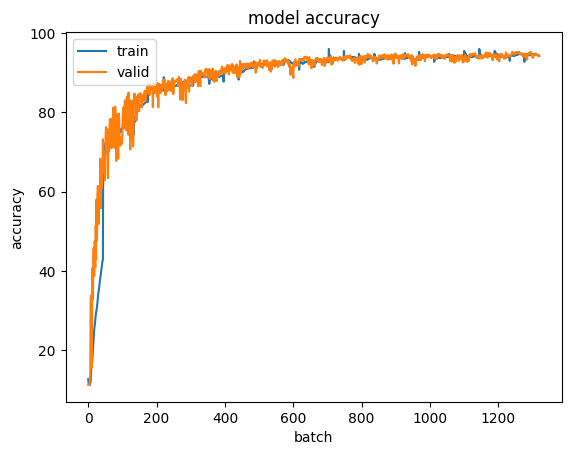

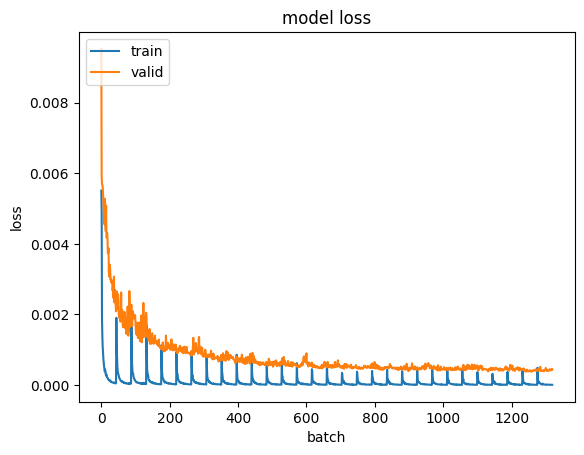

In [ ]:
# accuracy plot
plt.plot(history['train_acc'])
plt.plot( history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# loss plot
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sn

In [ ]:
model = CNN()
model.load_state_dict(torch.load('cnn_model_1000_e40_batch200.pt'))

class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3,
    'Scratch': 4,
    'Random': 5,
    'Near-full': 6,
    'Donut': 7,
    'none' : 8
}
idx2class = {v: k for k, v in class2idx.items()}

Precision: 0.9512723002137764
Recall: 0.9517487621193736
F1 Score: 0.9513337923045587


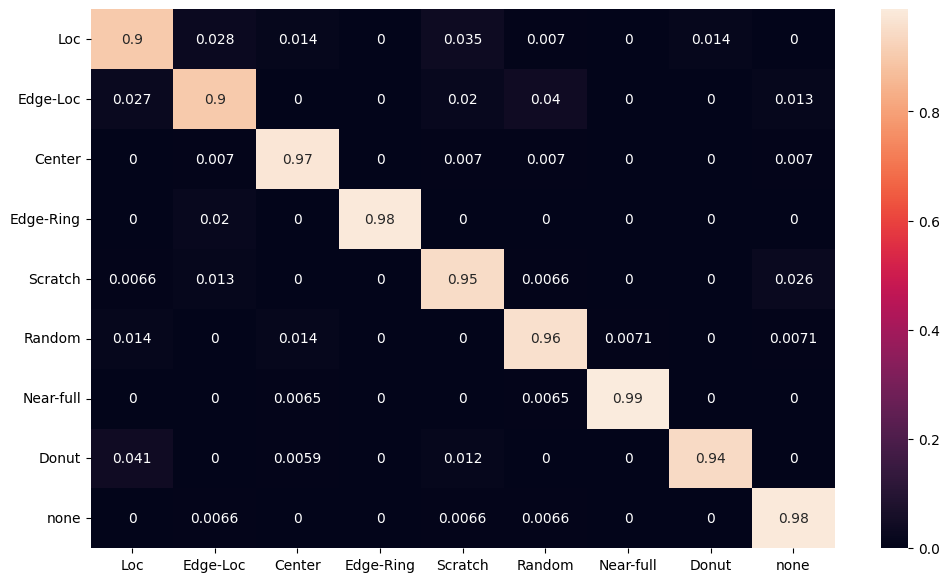

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for ti,(t_data,t_label) in enumerate(test_loader):
        output = model(t_data) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data
        y_pred.extend(output) # Save Prediction

        labels = t_label.data
        y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class2idx],
                     columns = [i for i in class2idx])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 Score:', f1)


In [ ]:
# 가면 갈수록 학습률 낮추기 학습률스케줄러
# 추적